In [1]:
from numpy import *
Nobs = 20
x_true = random.uniform(0,10, size=Nobs)
y_true = random.uniform(-1,1, size=Nobs)
alpha_true = 0.5
beta_x_true = 1.0
beta_y_true = 10.0
eps_true = 0.5
z_true = alpha_true + beta_x_true*x_true + beta_y_true*y_true
z_obs = z_true + random.normal(0, eps_true, size=Nobs)

Text(0, 0.5, 'Z')

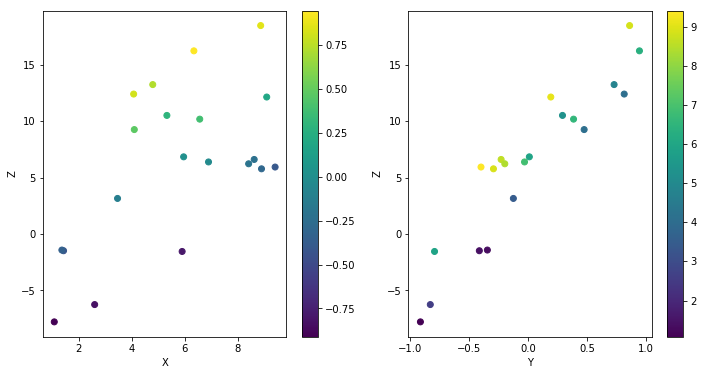

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x_true, z_obs, c=y_true, marker='o')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Z')
plt.subplot(1,2,2)
plt.scatter(y_true, z_obs, c=x_true, marker='o')
plt.colorbar()
plt.xlabel('Y')
plt.ylabel('Z')

In [3]:
def lnprior(p):
    # The parameters are stored as a vector of values, so unpack them
    alpha,betax,betay,eps = p
    # We're using only uniform priors, and only eps has a lower bound
    if eps <= 0:
        return -inf
    return 0

def lnlike(p, x, y, z):
    alpha,betax,betay,eps = p
    model = alpha + betax*x + betay*y
    # the likelihood is sum of the lot of normal distributions
    denom = power(eps,2)
    lp = -0.5*sum(power((z - model),2)/denom + log(denom) + log(2*pi))
    return lp

def lnprob(p, x, y, z):
    lp = lnprior(p)
    if not isfinite(lp):
        return -inf
    return lp + lnlike(p, x, y, z)

In [4]:
import scipy.optimize as opt
nll = lambda *args: -lnlike(*args)
print(nll)
result = opt.minimize(nll, [alpha_true, beta_x_true, beta_y_true, eps_true], #constantes
                      args=(x_true, y_true, z_obs)) #vectores
print(result['x'])

<function <lambda> at 0x000002789F7A36A8>
[ 0.76428004  0.95374493 10.38550424  0.60963695]


In [5]:
Nwalker,Ndim = 50,4
p0 = [result['x']+1.e-4*random.randn(Ndim) for i in range(Nwalker)]

In [6]:
import emcee
sampler = emcee.EnsembleSampler(Nwalker,Ndim,lnprob,
                                args=(x_true,y_true,z_obs))
pos,prob,state = sampler.run_mcmc(p0, 500)

In [7]:
#res=plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)
#axhline(alpha_true, color='blue')

NameError: name 'plot' is not defined

In [8]:
sampler.reset()
pos,prob,state = sampler.run_mcmc(pos, 1000)

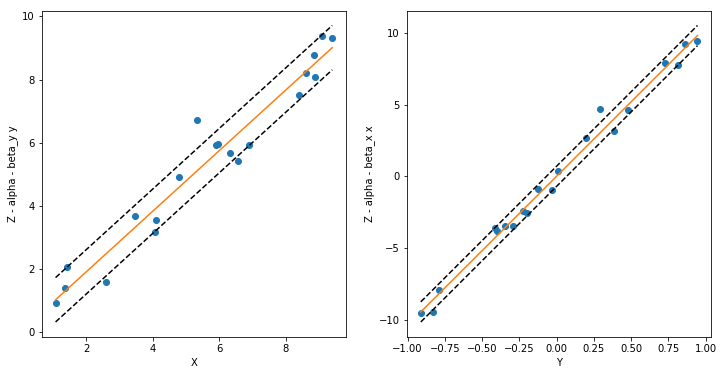

In [9]:
m_alpha,m_betax,m_betay,m_eps = median(sampler.flatchain, axis=0)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(x_true, z_obs-m_alpha-m_betay*y_true, 'o')
plt.xlabel('X')
plt.ylabel('Z - alpha - beta_y y')
# Now plot the model
xx = array([x_true.min(), x_true.max()])
plt.plot(xx, xx*m_betax)
plt.plot(xx, xx*m_betax + m_eps, '--', color='k')
plt.plot(xx, xx*m_betax - m_eps, '--', color='k')
plt.subplot(1,2,2)
plt.plot(y_true, z_obs-m_alpha-m_betax*x_true, 'o')
plt.xlabel('Y')
plt.ylabel('Z - alpha - beta_x x')
yy = array([y_true.min(), y_true.max()])
plt.plot(yy, yy*m_betay)
plt.plot(yy, yy*m_betay + m_eps, '--', color='k')
plt.plot(yy, yy*m_betay - m_eps, '--', color='k')

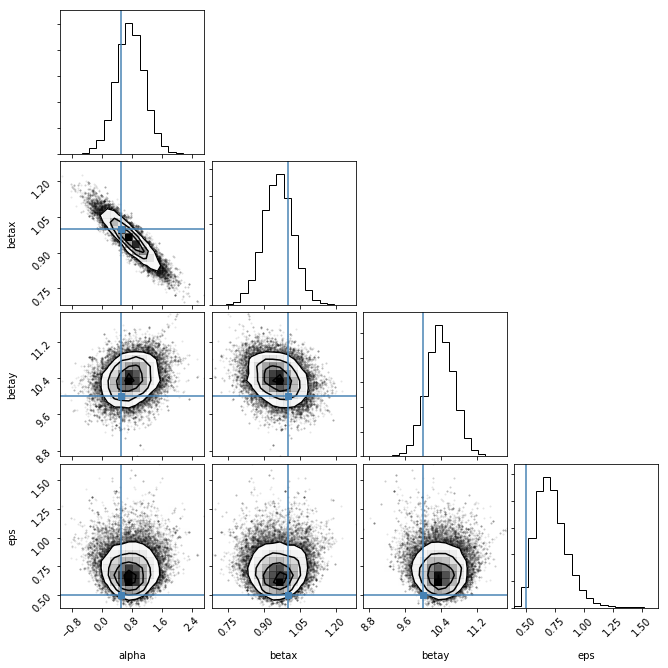

In [10]:
import corner
tmp = corner.corner(sampler.flatchain, labels=['alpha','betax','betay','eps'], 
                truths=[alpha_true, beta_x_true, beta_y_true, eps_true])